<a href="https://colab.research.google.com/github/SunnyWangW/Colab/blob/main/Forecast_Arima_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
# https://medium.com/@i.cemozcelik/data-science-project-sales-forecasting-with-arima-model-67321d547866
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

Mounted at /content/drive


(1)AR (Auto-Regressive): the time series is linearly regressed on its own past values

(2)I (Integrated): if not stationary, the time series can be differenced to become stationary,

i.e., compute the differences between consecutive observations

(3)MA (Moving Average): the time series is ‘regressed’ on the past forecast errors

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.3 MB/s eta 0:00:00


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas import DataFrame
import os

from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from pandas.plotting import autocorrelation_plot

from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.arima.model import ARIMA

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/shampoo.csv')
print(data.head())

  Month  Sales
0  1-01  266.0
1  1-02  145.9
2  1-03  183.1
3  1-04  119.3
4  1-05  180.3


In [11]:
len(data)

36

In [ ]:
for index,row in data.iterrows():
 print (index)
 print (row)

0
Month         1-01
Sales        266.0
Temp_date        0
Name: 0, dtype: object
1
Month         1-02
Sales        145.9
Temp_date        0
Name: 1, dtype: object
2
Month         1-03
Sales        183.1
Temp_date        0
Name: 2, dtype: object
3
Month         1-04
Sales        119.3
Temp_date        0
Name: 3, dtype: object
4
Month         1-05
Sales        180.3
Temp_date        0
Name: 4, dtype: object
5
Month         1-06
Sales        168.5
Temp_date        0
Name: 5, dtype: object
6
Month         1-07
Sales        231.8
Temp_date        0
Name: 6, dtype: object
7
Month         1-08
Sales        224.5
Temp_date        0
Name: 7, dtype: object
8
Month         1-09
Sales        192.8
Temp_date        0
Name: 8, dtype: object
9
Month         1-10
Sales        122.9
Temp_date        0
Name: 9, dtype: object
10
Month         1-11
Sales        336.5
Temp_date        0
Name: 10, dtype: object
11
Month         1-12
Sales        185.9
Temp_date        0
Name: 11, dtype: object
12
Month    

In [ ]:
data['Temp_date'] = 0
# print(data.head())
df= data.copy()
initial_year = 2019
counter = 0
for indx,row in df.iterrows():
    #print(indx)
    if counter < 12 :
        year = initial_year
    elif counter >=12 and counter <24:
        year = initial_year + 1
    elif counter >=24:
        year = initial_year + 2
    df['Temp_date'].iloc[indx] = str(year) + "-" + df['Month'].iloc[indx][2:]
    counter += 1


df['Month'] = df['Temp_date']
df.drop(columns = 'Temp_date', inplace = True)
df['Month'] = df['Month'] + "-" + "01"
df = df[0:36]

<ipython-input-5-c7cb3aaa0b42>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Temp_date'].iloc[indx] = str(year) + "-" + df['Month'].iloc[indx][2:]


In [ ]:
df.head()

,Month,Sales
0,2019-01-01,266.0
1,2019-02-01,145.9
2,2019-03-01,183.1
3,2019-04-01,119.3
4,2019-05-01,180.3


In [ ]:
df= df.set_index(['Month'])
df = df.rename({'Sales of shampoo over a three year period': 'Sales'}, axis=1)

<ipython-input-10-f0ced7e974a7>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df["Sales"], color = 'y')


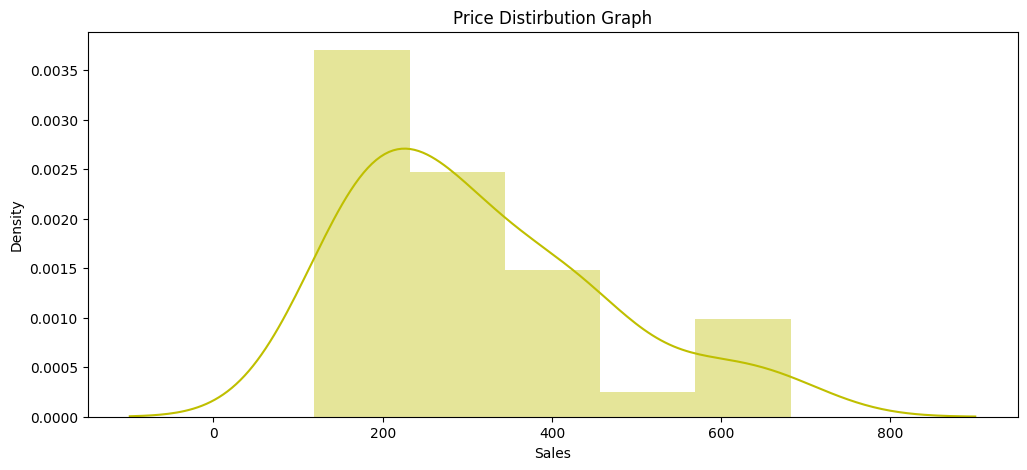

In [ ]:
plt.figure(figsize=(12,5))
plt.title("Price Distirbution Graph")
ax = sns.distplot(df["Sales"], color = 'y')

Use AIC test to check stationary.
If P <0.05 - >The data is stationary.
If p> 0.05 -> Data are not stationary.

In [ ]:
def ad_test(dataset):

    dftest = adfuller(dataset, autolag = 'AIC')

    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:",dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
         print("\t",key, ": ", val)


ad_test(df['Sales'])

1. ADF :  3.060142083641181
2. P-Value :  1.0
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression: 25
5. Critical Values :
	 1% :  -3.7238633119999998
	 5% :  -2.98648896
	 10% :  -2.6328004


P value is 1.0 and the shampoo data is not stationary.

We need use Difference method to make the data stationary.

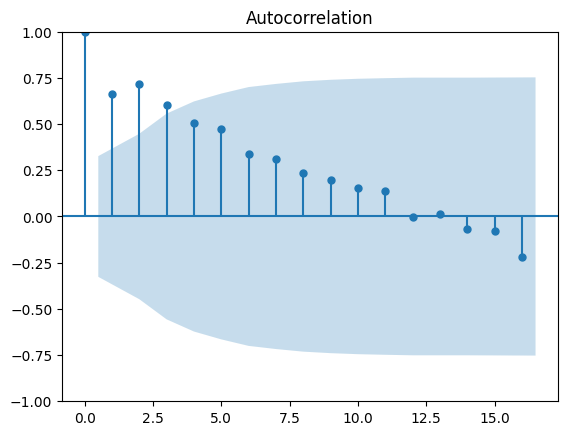

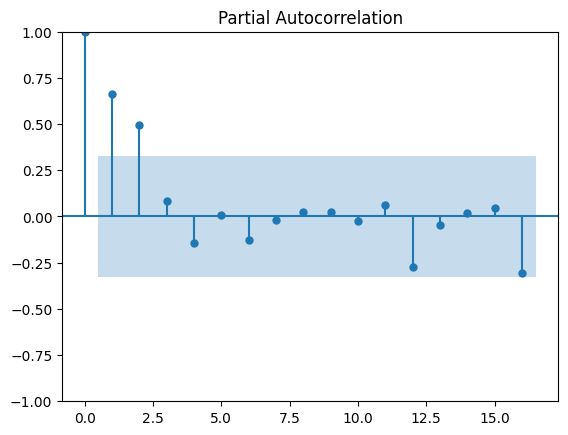

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_original = plot_acf(df['Sales'])
pacf_original = plot_pacf(df['Sales'])

(1) use ACF and PACF(Partial Autocorrelation) to choose arima model

(2) p = from PACF , because the PACF has a large spike at lag 3.

(3) q = from ACF , ACF decay after lag 2,3 .

In [ ]:
#Use auto arima package to choose model.
stepwise_fit = auto_arima(df['Sales'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=430.873, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=405.977, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=408.967, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=429.229, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=403.573, Time=0.31 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=404.633, Time=0.54 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=404.226, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=402.407, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=401.463, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best 

In [26]:
# Cross-Validation
X = df.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()


In [20]:
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=349.970807, expected=342.300000
predicted=286.003055, expected=339.700000
predicted=341.015454, expected=440.400000
predicted=341.819704, expected=315.900000
predicted=391.521270, expected=439.300000
predicted=339.753099, expected=401.300000
predicted=424.993908, expected=437.400000
predicted=387.268988, expected=575.500000
predicted=468.852028, expected=407.600000
predicted=503.761977, expected=682.000000
predicted=460.691662, expected=475.300000
predicted=613.988012, expected=581.300000
predicted=521.714870, expected=646.900000


In [16]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 90.986


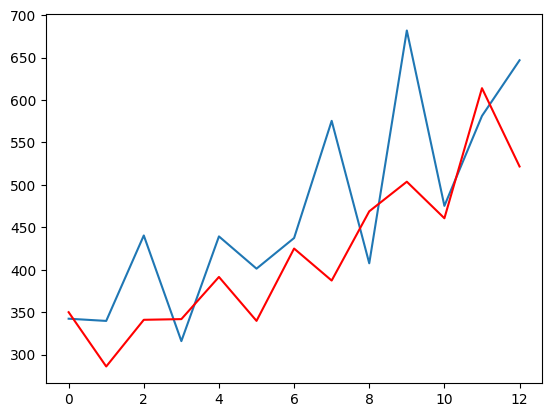

In [ ]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [32]:
predictions1 = list()
for t in range(len(test)):
    model = ARIMA(history, order=(3,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions1.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=536.748303, expected=342.300000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=570.211026, expected=339.700000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=375.896953, expected=440.400000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=317.599600, expected=315.900000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=437.571370, expected=439.300000
predicted=355.912761, expected=401.300000
predicted=389.947424, expected=437.400000
predicted=457.440389, expected=575.500000
predicted=439.780851, expected=407.600000
predicted=521.219355, expected=682.000000
predicted=547.642498, expected=475.300000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=555.786167, expected=581.300000
predicted=598.995105, expected=646.900000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [33]:
rmse = sqrt(mean_squared_error(test, predictions1))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 106.853


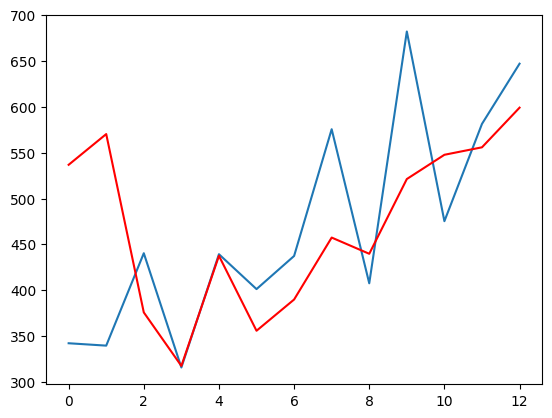

In [34]:
pyplot.plot(test)
pyplot.plot(predictions1, color='red')
pyplot.show()